In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# 'mf' = 'music_face'
mf = pd.read_csv("data/joined_data.csv")

print(f"mf.shape: {mf.shape}")
mf.head(3)

mf.shape: (14857, 12)


,timestamp,angry,scared,happy,sad,surprised,neutral,end_time,artist_name,track_name,time_played,start_time
0,2019-12-19 11:25:38+00:00,0.069113,0.109064,0.000982,0.557766,0.001962,0.261114,2019-12-19 11:27:00+00:00,Underground Springhouse,Joyfell,0 days 00:01:26.520000000,2019-12-19 11:25:33.480000+00:00
1,2019-12-19 11:25:53+00:00,0.024520,0.151708,0.001428,0.775339,0.001056,0.045949,2019-12-19 11:27:00+00:00,Underground Springhouse,Joyfell,0 days 00:01:26.520000000,2019-12-19 11:25:33.480000+00:00
2,2019-12-19 11:26:08+00:00,0.076808,0.146932,0.000880,0.598738,0.002113,0.174530,2019-12-19 11:27:00+00:00,Underground Springhouse,Joyfell,0 days 00:01:26.520000000,2019-12-19 11:25:33.480000+00:00


<IPython.core.display.Javascript object>

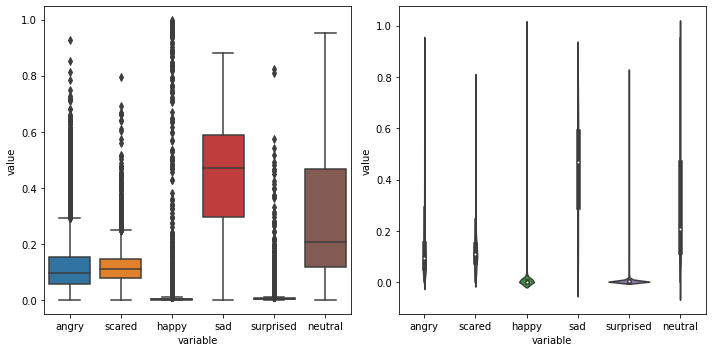

<IPython.core.display.Javascript object>

In [4]:
plot_df = mf[["angry", "scared", "happy", "sad", "surprised", "neutral"]]
plot_df = plot_df.melt()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot("variable", "value", data=plot_df, ax=axes[0])
sns.violinplot("variable", "value", data=plot_df, ax=axes[1])
plt.tight_layout()
plt.show()

In [5]:
mf["top_emotion"] = mf[
    ["angry", "scared", "happy", "sad", "surprised", "neutral"]
].idxmax(axis=1)
mf["top_emotion"].value_counts()

sad          9659
neutral      4565
angry         422
happy         111
scared         77
surprised      23
Name: top_emotion, dtype: int64

<IPython.core.display.Javascript object>